<a href="https://colab.research.google.com/github/macscheffer/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

In [2]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv')

df.shape

(1460, 81)

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [0]:
import numpy as np

np.log(df.SalePrice).plot.hist()

In [0]:
df['logprice'] = np.log(df.SalePrice)

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

X = df.loc[:, ['LotArea']].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))

In [10]:
pd.set_option('display.max_columns', 500)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,logprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,12.247694
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,12.109011
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,12.317167
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,11.849398
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,12.429216


In [34]:
features = ['LotArea', 'OverallQual']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.219812430665842

In [35]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.18045001504174427

In [36]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17990333103566045

In [0]:
df['fullhalfbath_interaction'] = df.FullBath * df.HalfBath

In [37]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17941350562118014

In [39]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17876742238505144

In [47]:
df.YrSold.value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [0]:
df['sold_pre_2008'] = (df.YrSold < 2008)

In [51]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.17857500842915905

In [0]:
df['age_sold'] = df.YrSold - df.YearBuilt

In [55]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.16116941915293145

In [0]:
df['years_since_remod'] = df.YrSold - df.YearRemodAdd

In [64]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1617161233871106

In [0]:
df['age_remod_interaction'] = df.age_sold * df.years_since_remod

In [66]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1613351041518322

In [77]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.15511110951231402

In [0]:
df['floor_interaction'] = df['1stFlrSF'] * df['2ndFlrSF']

In [81]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.1548967916031227

In [84]:
df.MSZoning.value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [86]:
df.pivot_table(index='MSZoning', values='SalePrice')

,SalePrice
MSZoning,
C (all),74528.000000
FV,214014.061538
RH,131558.375000
RL,191004.994787
RM,126316.830275


In [0]:
df['mszoning_RL'] = (df.MSZoning == 'RL')
df['mszoning_c'] = (df.MSZoning == 'C (all)')
df['mszoning_RM'] = (df.MSZoning == 'RM')
df['mszoning_FV'] = (df.MSZoning == 'FV')

In [104]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14361104119158047

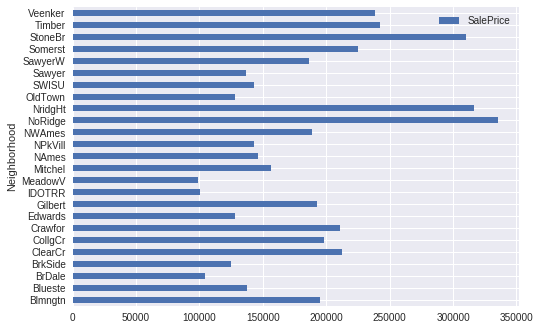

In [107]:
df.pivot_table(index='Neighborhood', values='SalePrice').plot.barh()

In [0]:
df['good_area'] = ((df.Neighborhood == 'NoRidge') | (df.Neighborhood == 'NridgeHt') | (df.Neighborhood == 'StoneBr'))
df['bad_area'] = ((df.Neighborhood == 'MeadowV') | (df.Neighborhood == 'IDOTRR') | (df.Neighborhood == 'BrDale'))

In [111]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14186182624711163

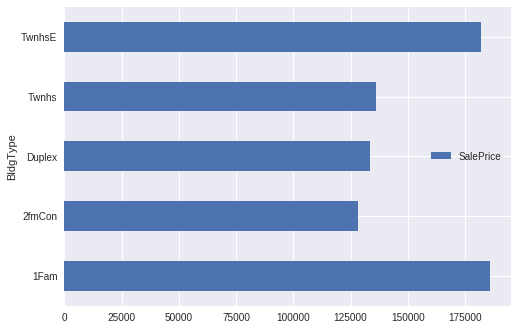

In [126]:
df.pivot_table(index='BldgType', values='SalePrice').plot.barh()

In [0]:
df['one_fam_home'] = (df.BldgType == '1Fam')
df['townhouse'] = (df.BldgType == 'TwnhsE')

In [128]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14124045155434384

In [135]:
df.MiscFeature.value_counts()

Shed    49
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

In [0]:
df.MiscFeature = df.MiscFeature.fillna('None')

In [0]:
df['miscfeature_isnone'] = (df.MiscFeature == 'None')
df['has_shed'] = (df.MiscFeature == 'Shed')

In [145]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14109409861043737

In [148]:
df.SaleType.value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [0]:
df['new_home'] = (df.SaleType == 'New')

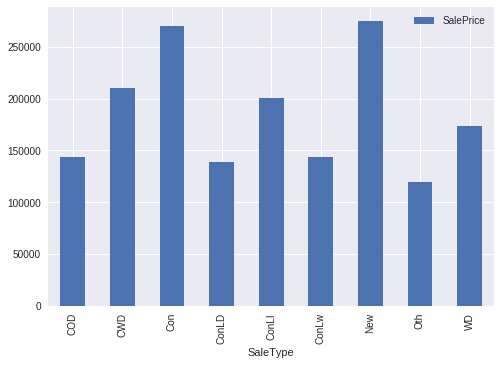

In [150]:
df.pivot_table(index='SaleType', values='SalePrice').plot.bar()

In [152]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14100611102880925

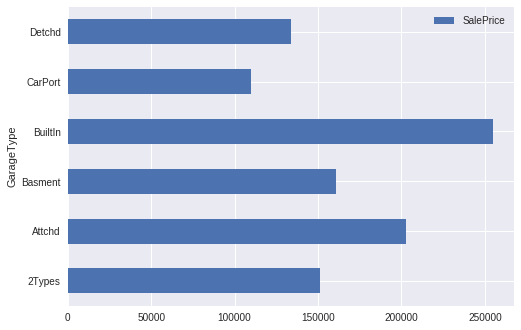

In [159]:
df.pivot_table(index='GarageType', values='SalePrice').plot.barh()

In [0]:
df['attached_garage'] = (df.GarageType == 'Attchd')
df['detchd_garage'] = (df.GarageType == 'Detchd')

In [163]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage', 'detchd_garage']
X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.14092730778459361

In [0]:
df['lotarea_squared'] = df.LotArea ** 2
df['overallqual_squared'] = df.OverallQual ** 2
df['overallcond_squared'] = df.OverallCond ** 2


In [166]:
features = ['LotArea', 'OverallQual', 'OverallCond', 'GrLivArea','GarageArea', 'GarageCars', 'FullBath', 'HalfBath', 'fullhalfbath_interaction', 'BedroomAbvGr',
            'sold_pre_2008', 'age_sold', 'years_since_remod', 'age_remod_interaction', '1stFlrSF', '2ndFlrSF', 'floor_interaction', 'mszoning_RL', 'mszoning_c',
            'mszoning_RM', 'mszoning_FV', 'good_area', 'bad_area', 'one_fam_home', 'townhouse', 'miscfeature_isnone', 'has_shed', 'new_home', 'attached_garage',
            'detchd_garage', 'lotarea_squared', 'overallqual_squared', 'overallcond_squared']

X = df[features].values
y = df.loc[:,['logprice']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


lr = LinearRegression()
lr.fit(X_train, y_train)


oos_pred = lr.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse

0.13923297083881975

# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data

In [167]:
from sklearn.ensemble import GradientBoostingRegressor



targets = df.logprice
inputs = df[features]

X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.25)

rfg = GradientBoostingRegressor(n_estimators=1000, max_depth=4, learning_rate=.05, random_state=42)
rfg.fit(X_train, y_train)

oos_pred = rfg.predict(X_test)
oos_mse = mean_squared_error(y_test, oos_pred)
oos_r2 = r2_score(y_test, oos_pred)
rmse = (np.sqrt(oos_mse))
rmse, oos_r2, oos_mse

(0.1747076975757598, 0.8015555325358862, 0.030522779592223145)